In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import time

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
data = pd.read_csv('TSLA.csv')
data = data['Open']

In [4]:
print(data.shape)

(2227,)


## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [5]:
scaler = MinMaxScaler()
x = scaler.fit_transform(data.values.reshape((-1,1)))

In [255]:
print(x)

[[0.00771826]
 [0.02604237]
 [0.02391041]
 ...
 [0.60102552]
 [0.61902578]
 [0.61454595]]


# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [256]:
import copy
def batch_generator(data, batch_size,num_seq):
    data1 = copy.deepcopy(data)
    # generate sequence
    x_s = []
    y_s = []
    for i in range(len(data1)-num_seq):
        x_s.append(data1[i:i+num_seq])
        y_s.append(data1[i+num_seq])
        
    # generate batch    
    start_idx = 0
    end_idx = batch_size
    while end_idx < len(data):
        x = np.reshape(x_s[start_idx:end_idx],(batch_size,num_seq,1))
        y = np.reshape(y_s[start_idx:end_idx],(batch_size,1))
        yield(x,y)
        start_idx += batch_size
        end_idx += batch_size

In [257]:

train_data,val_data,test_data = data[:1827].values,data[1827:2027].values,data[2027:].values


In [258]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1827,)
(200,)
(200,)


# TesnorFlow Model

In [265]:
epoch = 5000
#unrolled through 8 time steps
num_seq=7
#hidden LSTM units
num_units=100
# each cell input 1 
input_size=1
output_size = 1
#learning rate for adam
learning_rate=0.001

#size of batch
batch_size=128


In [266]:
tf.reset_default_graph()

In [267]:
X = tf.placeholder(tf.float64,[None,num_seq,input_size],name='X')
Y = tf.placeholder(tf.float64,[None,output_size],name='Y')

In [268]:
def lstm(X):
    lstm_cell=tf.contrib.rnn.BasicLSTMCell(num_units,forget_bias=1)
    initial_state = lstm_cell.zero_state(batch_size,dtype=tf.float64)
    #  output shape :[batch_size, num_seq, cell.output_size] final_state: [batch_size, cell.output_size]
    outputs,final_state = tf.nn.dynamic_rnn(cell = lstm_cell, inputs = X, initial_state = initial_state,dtype="float64")
    return outputs

In [269]:
Y_pred = tf.contrib.layers.fully_connected(lstm(X)[:,-1,:],output_size)
#loss_function
# loss=tf.losses.mean_squared_error(Y,Y_pred)
loss = tf.reduce_sum(tf.square(Y-Y_pred))
#optimization
opt=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)


# Training

Training finished!


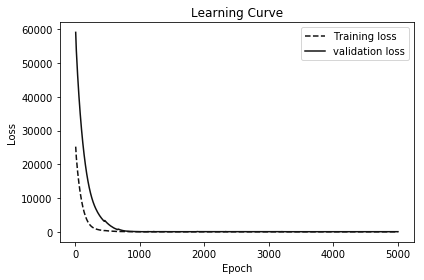

In [270]:
epoch_list = []
train_loss_list = []
val_loss_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1,epoch+1):
        #fetch batch
        training_data = batch_generator(train_data, batch_size,num_seq)
        for t_data, labels in training_data:
            f_dict = {X: t_data, Y: labels}
            sess.run(opt, feed_dict=f_dict)

                
        if(i%10 == 0):
            epoch_list.append(i)
            
            train_loss = 0
            training_data = batch_generator(train_data, batch_size,num_seq)
            for t_data, labels in training_data:
                f_dict = {X: t_data, Y: labels}
                train_loss += sess.run(loss, feed_dict=f_dict)
            train_loss /= len(train_data)
            train_loss_list.append(train_loss)
            
            val_loss = 0
            validation_data = batch_generator(val_data, batch_size,num_seq)
            for v_data, labels in validation_data:
                f_dict = {X: v_data, Y: labels}
                val_loss += sess.run(loss, feed_dict=f_dict)
            val_loss /=len(val_data)
            val_loss_list.append(val_loss)


#             print('Epoch'+str(i),"train loss= {:.3f}".format(train_loss),"validation loss= {:.3f}".format(val_loss))
    
    
    print("Training finished!")
# Draw lines
plt.plot(epoch_list,train_loss_list,  '--', color="#111111",  label="Training loss")
plt.plot(epoch_list,val_loss_list,  color="#111111", label="validation loss")


# Create plot
plt.title("Learning Curve")
plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()


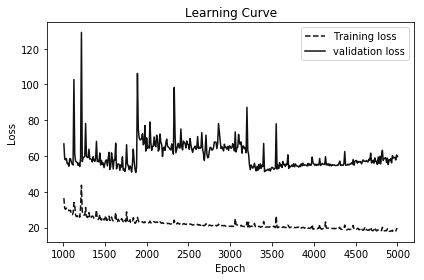

In [274]:
# Draw lines
plt.plot(epoch_list[100:],train_loss_list[100:],  '--', color="#111111",  label="Training loss")
plt.plot(epoch_list[100:],val_loss_list[100:],  color="#111111", label="validation loss")


# Create plot
plt.title("Learning Curve")
plt.xlabel("Epoch"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()



# Testing

In [276]:
from tqdm import tqdm
prediction = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in tqdm(range(1,1880)):
        #fetch batch
        training_data = batch_generator(train_data, batch_size,num_seq)
        for t_data, labels in training_data:
            f_dict = {X: t_data, Y: labels}
            sess.run(opt, feed_dict=f_dict)
        
    testing_data = batch_generator(test_data, batch_size,num_seq)
    for tt_data, labels in testing_data:
        f_dict = {X: tt_data, Y: labels}
        prediction.append(sess.run(Y_pred, feed_dict=f_dict))


100%|██████████| 1879/1879 [05:27<00:00,  6.70it/s]


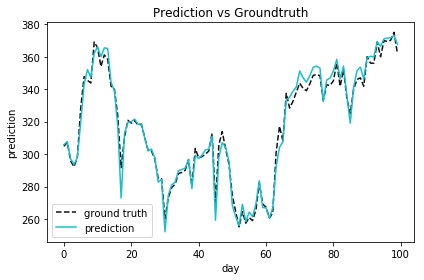

In [291]:
# Draw lines
plt.plot(test_data[num_seq-1:100+num_seq-1],  '--', color="#111111",  label="ground truth")
plt.plot(prediction[0][:100],  color="#1ABFCF", label="prediction")


# Create plot
plt.title("Prediction vs Groundtruth")
plt.xlabel("day"), plt.ylabel("prediction"), plt.legend(loc="best")
plt.tight_layout()
plt.show()